In [4]:
# !wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

In [2]:
import json
import pandas as pd

from PIL import Image
import requests
from io import BytesIO

In [3]:
image_dataframe = pd.read_csv('data/identifiers.csv')

In [4]:
from os import listdir
import cv2
from numpy import asarray
import numpy as np

 
# extract a single face from a given photograph
def extract_face_show(image, required_size=(160, 160)):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, 1.1, 4)

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    # Display the output
    cv2.imshow('img', img)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [5]:
def extract_face(image, required_size=(160, 160), idf=0):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    # Read the input image
    img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(img, 1.03, 5) #play with parameters for better detection
    # Draw rectangle around the faces
    i=0
    for (x, y, w, h) in faces:
        r = max(w, h) / 2
        centerx = x + w / 2
        centery = y + h / 2
        nx = int(centerx - r)
        ny = int(centery - r)
        nr = int(r * 2)

        faceimg = img[ny:ny+nr, nx:nx+nr]
        lastimg = cv2.resize(faceimg, (32, 32))
        i += 1
        print(x, y, w, h)
        cv2.imwrite(f"images/image{i}_{idf}.jpg", lastimg)
        print(f'write {idf}')

Haar gives a lot of false positives, better methods exit. we can get slightly improved results by adapting resizing the image and adapting the thresold

In [40]:
sample = image_dataframe.identifier.sample(100)
sample.to_csv('images/sample.csv')
for doc in sample:
    url = doc+'/f1.highres.jpg'
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    width, height = img.size
    factor = 500/width
    extract_face(img.resize((int(width*factor), int(factor*height))), idf=doc[-len('btv1b53134455m'):])

/anaconda3/envs/fdh/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


454 263 106 106
write btv1b53170703n
174 412 68 68
write btv1b53170703n
619 458 51 51
write btv1b53170703n
740 603 34 34
write btv1b53170703n
707 527 67 67
write btv1b53170703n
301 672 45 45
write btv1b53170703n
363 695 30 30
write btv1b53170703n
511 1024 53 53
write btv1b53170703n
458 405 153 153
write btv1b531448273
195 582 617 617
write btv1b531448273
897 735 57 57
write btv1b531448273
330 147 331 331
write btv1b53191447x
462 255 92 92
write btv1b53191447x
484 237 97 97
write btv1b531810473
22 381 30 30
write btv1b531810473
659 883 70 70
write btv1b531810473
32 422 68 68
write btv1b530507241
414 469 159 159
write btv1b530507241
529 768 69 69
write btv1b530507241
208 1213 31 31
write btv1b530507241
216 136 597 597
write btv1b53152385d
425 872 267 267
write btv1b53152385d
405 255 161 161
write btv1b531755561
406 526 28 28
write btv1b531755561
572 469 122 122
write btv1b531755561
400 663 381 381
write btv1b531755561
456 294 100 100
write btv1b53120234w
378 590 48 48
write btv1b53120234

417 497 177 177
write btv1b53071723j
783 760 40 40
write btv1b53071723j
892 1440 36 36
write btv1b53071723j
19 1321 52 52
write btv1b53071723j
342 309 90 90
write btv1b53159934k
837 440 81 81
write btv1b53159934k
250 728 39 39
write btv1b53159934k
704 711 162 162
write btv1b53159934k
731 844 112 112
write btv1b53159934k
432 290 160 160
write btv1b53175620g
561 691 106 106
write btv1b53175620g
687 882 28 28
write btv1b53175620g
693 905 29 29
write btv1b53175620g
361 913 30 30
write btv1b53175620g
359 894 41 41
write btv1b53175620g
364 1078 26 26
write btv1b53175620g
427 999 92 92
write btv1b53175620g
393 335 163 163
write btv1b53080329p
507 757 54 54
write btv1b53080329p
505 1088 35 35
write btv1b53080329p
420 349 282 282
write btv1b531395313
407 664 171 171
write btv1b531395313
687 954 43 43
write btv1b531395313
663 245 30 30
write btv1b531935364
645 346 69 69
write btv1b531935364
821 867 31 31
write btv1b531935364
644 919 28 28
write btv1b531935364
382 250 90 90
write btv1b53117488m
3

In [8]:
import os

In [36]:
LOCATION = '../humans_of_paris/app/static/images/'
pictures = os.listdir(LOCATION)

In [23]:
image = Image.open(LOCATION + 'btv1b53071525p.png')

In [24]:

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(img, 1.1, 4)

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

In [25]:
faces

array([[120, 111,  95,  95],
       [ 59, 279,  40,  40],
       [165, 291,  35,  35]], dtype=int32)

In [31]:
model = MTCNN()

In [37]:
image = Image.open(LOCATION + 'btv1b53071525p.jpg')
img = np.array(image)
faces = model.detect_faces(img)

In [38]:
faces

[]

look at MTCNN which is a state of the art model for face detection (and related tasks). Install the module mtcnn but make sure to have a tensorflow version older than 2.0, so for instance 1.13.1

still some false positives but markedly better, need to check for false negatives

In [28]:
from mtcnn.mtcnn import MTCNN

Using TensorFlow backend.


In [29]:
model = MTCNN()

def extract_face_cnn(img, idf=0):
    img = np.array(img)
    faces = model.detect_faces(img)
    i=0
    for face in faces:
        box = face['box']
        (x, y, w, h) = (box[0], box[1], box[2], box[3])
        r = max(w, h) / 2
        centerx = x + w / 2
        centery = y + h / 2
        nx = int(centerx - r)
        ny = int(centery - r)
        nr = int(r * 2)

        faceimg = img[ny:ny+nr, nx:nx+nr]
        lastimg = cv2.resize(faceimg, (32, 32))
        i += 1
        print(x, y, w, h)
        cv2.imwrite(f"images/image{i}_{idf}.jpg", lastimg)
        print(f'write {idf}')

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
from PIL import Image
import requests
from io import BytesIO

sample = pd.read_csv('images/sample.csv', header=None, index_col=0)[1]
for doc in sample:
    url = doc+'/f1.highres.jpg'
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    width, height = img.size
    factor = 500/width
    extract_face_cnn(img,  idf=doc[-len('btv1b53134455m'):])

Analyzing facial vectors & clustering

# cropping images

In [24]:
def crop(img, minx, miny, maxx, maxy):
    return img[miny:maxy, minx:maxx]


def get_image(doc):
    url = doc+'/f1.highres.jpg'
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = np.array(img)
    return img

In [25]:
def get_face_image(doc):
    output_file = '../humans_of_paris/app/static/images/'+doc.id.split('/')[-1]+'.jpg'
    img = get_image(doc.id)
    cropped = crop(img, int(doc.left), int(doc.top), int(doc.right), int(doc.bottom))
    cv2.imwrite(output_file,  cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR))

In [18]:
age_gender_lables

,left,top,right,bottom,width,height,gender,age,number,id,name
0,269.0,268.0,748.0,747.0,479.0,479.0,0.116277,47.741472,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53071608k,"Abbatucci, Séverin"
1,433.0,316.0,580.0,463.0,147.0,147.0,0.585720,27.465579,2.0,https://gallica.bnf.fr/ark:/12148/btv1b531622212,"Abbott, Emma"
2,250.0,718.0,403.0,871.0,153.0,153.0,0.377803,40.358822,3.0,https://gallica.bnf.fr/ark:/12148/btv1b53071525p,"Abbéma, Louise"
3,155.0,134.0,872.0,851.0,717.0,717.0,0.104841,44.487285,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53165139q,"Abney, William de Wiveleslie"
4,415.0,184.0,615.0,384.0,200.0,200.0,0.389818,27.194442,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53117510h,"Abott, Bessie"
...,...,...,...,...,...,...,...,...,...,...,...
1881,292.0,351.0,658.0,717.0,366.0,366.0,0.025766,47.032899,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53098072j,Édouard VII
1882,355.0,310.0,596.0,551.0,241.0,241.0,0.033713,45.716630,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53065399p,"Énault, Louis"
1883,288.0,437.0,583.0,732.0,295.0,295.0,0.358721,26.078685,1.0,https://gallica.bnf.fr/ark:/12148/btv1b530664193,"Éon, Charles de Beaumont d'"
1884,310.0,214.0,739.0,643.0,429.0,429.0,0.108013,47.732863,1.0,https://gallica.bnf.fr/ark:/12148/btv1b531271467,"Étex, Antoine"


In [19]:
import os

In [35]:
collected = set([x[:-len('.jpg')] for x in os.listdir('./images')])

In [47]:
len(os.listdir('./images'))

1739

In [26]:
age_gender_lables = pd.read_json('age_gender_labeles.json')

In [38]:
to_collect = set(age_gender_lables.dropna().id.map(lambda x: x.split('/')[-1]).tolist()).difference(collected)

In [12]:
import numpy as np

In [28]:
age_gender_lables.dropna()[400:].apply(lambda x: get_face_image(x), axis=1)

421     None
422     None
423     None
424     None
425     None
        ... 
1881    None
1882    None
1883    None
1884    None
1885    None
Length: 1411, dtype: object

# Alternative face map clustering

In [64]:
import matplotlib.pyplot as plt

In [65]:
import numpy as np

In [66]:
with open('faces.json') as f:
    d = f.read()
    
face = pd.DataFrame(json.loads(d))

In [67]:
age_gender_lables = pd.read_json('age_gender_labeles.json')

In [68]:
face = pd.merge(face, age_gender_lables, on='id')

In [71]:
import numpy as np
from scipy.spatial import distance
import pandas as pd

def get_similar_people(target, k=4):
    """get k most similar persons in facial vectors
        target: vector from openface
    
    """
    
    # load face_vectors
    with open('../notebooks/faces.json') as f:
        d = f.read()
    face = pd.DataFrame(json.loads(d))
    
    matrix = face.face.tolist()
    distances = distance.cdist([target], matrix, "cosine")[0]

    idx = np.argpartition(distances, k)
    closest_indices = idx[:k]
    return [x.split('/')[-1] for x in face.iloc[closest_indices].id.tolist()]

In [72]:
get_similar_people(face.iloc[0].face)

['btv1b53071608k', 'btv1b53066412z', 'btv1b53065430j', 'btv1b530719078']

In [73]:
face.iloc[closest_indices[1]+1]

id         https://gallica.bnf.fr/ark:/12148/btv1b530719078
face      [0.019463879987597, 0.013958753086627, -0.0627...
left                                                    300
top                                                     286
right                                                   788
bottom                                                  774
width                                                   488
height                                                  488
gender                                            0.0973844
age                                                 53.7528
number                                                    1
name                                            Bury, Henri
Name: 918, dtype: object

In [74]:
face.iloc[0]

id         https://gallica.bnf.fr/ark:/12148/btv1b53071608k
face      [0.0059239729307592, 0.052486442029476, -0.053...
left                                                    269
top                                                     268
right                                                   748
bottom                                                  747
width                                                   479
height                                                  479
gender                                             0.116277
age                                                 47.7415
number                                                    1
name                                     Abbatucci, Séverin
Name: 0, dtype: object

In [75]:
references = face.iloc[:100].id.map(lambda x:  x.split('/')[-1]+'.jpg').tolist()
matrix = face.iloc[:100].face.tolist()

In [76]:
face_json = {'users': references, 'mat': matrix}

In [93]:
gender_lables = face.gender

In [77]:
matrix = face.face.tolist()

In [78]:
matrix = np.array(matrix)

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [80]:
x_pca = pca.fit_transform(matrix)

In [94]:
gender_lables = gender_lables.map(lambda x: 0 if x < .5 else 1)

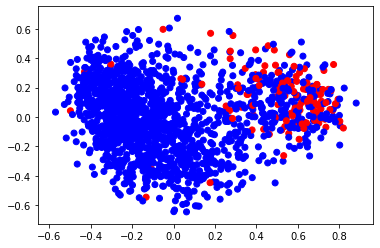

In [111]:
plt.scatter(x_pca[:,0], x_pca[:,1], c = gender_lables, cmap=plt.cm.bwr)

In [39]:
x_pca = (x_pca - x_pca.min())*200+100

In [96]:
from sklearn import random_projection

In [97]:
import numpy as np

In [122]:
transformer = random_projection.SparseRandomProjection(n_components=2, density=.99)
X_new = transformer.fit_transform(matrix)

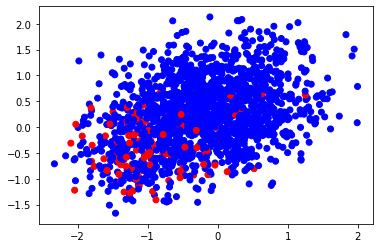

In [123]:
plt.scatter(X_new[:,1], X_new[:,0], c = gender_lables, cmap=plt.cm.bwr)

In [126]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(matrix)

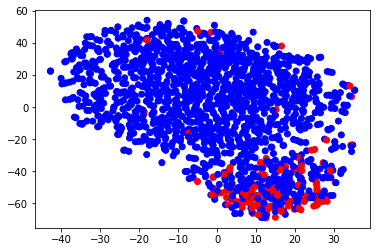

In [127]:
plt.scatter(X_embedded[:,1], X_embedded[:,0], c = gender_lables, cmap=plt.cm.bwr)

# importance of faces

In [132]:
fame = pd.read_pickle('data/merged_dataframe.pkl')#.rank_fr.plot(kind='hist', bins=100)

In [143]:
fame.sort_values(by='rank_fr')[['name', 'rank_fr', 'id']].dropna()[:100]

,name,rank_fr,id
235,"Bouguereau, William (1825-1905)",1.0,https://gallica.bnf.fr/ark:/12148/btv1b53050879q
580,"Dieterle, Amélie (1870-1941)",2.0,https://gallica.bnf.fr/ark:/12148/btv1b53111808r
1629,"Sand, George (1804-1876)",3.0,https://gallica.bnf.fr/ark:/12148/btv1b53066110x
1171,"Manet, Édouard (1832-1883)",4.0,https://gallica.bnf.fr/ark:/12148/btv1b53066421x
1573,"Robespierre, Maximilien de (1758-1794)",5.0,https://gallica.bnf.fr/ark:/12148/btv1b53187673w
...,...,...,...
1599,"Rousseau, Théodore (1812-1867)",109.0,https://gallica.bnf.fr/ark:/12148/btv1b53120269c
1133,"Loubet, Émile (1838-1929)",109.0,https://gallica.bnf.fr/ark:/12148/btv1b53117467b
1448,"Picot, François Édouard (1786-1868)",109.0,https://gallica.bnf.fr/ark:/12148/btv1b53050696f
549,"Derré, Emile (1867-1938)",109.0,https://gallica.bnf.fr/ark:/12148/btv1b53118812w


In [176]:
famous_id = fame.sort_values(by='rank_fr')[['name', 'rank_fr', 'id']].dropna()[:250].id.tolist()

In [177]:
cond = face.id.isin(famous_id)

In [178]:
references = face[cond].id.map(lambda x: x.split('/')[-1]+'.jpg').tolist()

In [179]:
names = face[cond].name.tolist()

In [180]:
matrix = face[cond].face.tolist()
matrix = np.array(matrix)

In [181]:
x_pca = pca.fit_transform(matrix)
x_pca = (x_pca - x_pca.min())*200+100

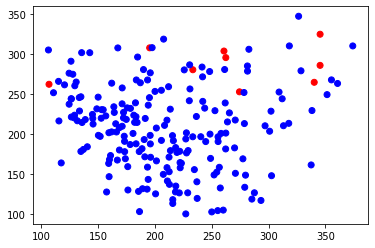

In [182]:
gender_lables = face[cond].gender
gender_lables = gender_lables.map(lambda x: 0 if x < .5 else 1)

plt.scatter(x_pca[:,0], x_pca[:,1], c = gender_lables, cmap=plt.cm.bwr)

In [183]:
tuples = list(zip(references, names, x_pca.tolist()))

face_json = {'users': tuples}

with open('../humans_of_paris/app/static/clustered.json', 'w') as outfile:
    json.dump(face_json, outfile)

In [175]:
face_json

{'users': [('btv1b53050602x.jpg',
   'Lazerges, Hippolyte',
   [215.39340699398525, 259.83054861801315]),
  ('btv1b53065617m.jpg',
   'Lefranc, Victor',
   [213.577197321926, 308.269303671957]),
  ('btv1b53104347s.jpg',
   'Leleux, Adolphe',
   [174.44735069803806, 225.86461395971747]),
  ('btv1b53169003s.jpg',
   'Lemaire, Madeleine',
   [260.2457032216449, 276.3595816423983]),
  ('btv1b53081619r.jpg',
   'Lepère, Charles',
   [171.9977340391219, 221.1750393131113]),
  ('btv1b53107167w.jpg',
   'Leriche, Augustine',
   [288.38817828614935, 274.466811088212]),
  ('btv1b53081576h.jpg',
   'Lesseps, Ferdinand de',
   [142.11973411277245, 207.8970083228835]),
  ('btv1b53118945v.jpg',
   'Balzac, Honoré de',
   [209.13187986307076, 150.54573890391157]),
  ('btv1b53118904r.jpg',
   'Lhermitte, Léon',
   [193.51382123587288, 210.80737094878214]),
  ('btv1b53107869f.jpg',
   'Liszt, Franz',
   [171.09274784805208, 262.4718688383355]),
  ('btv1b53139302j.jpg',
   'Littré, Émile',
   [133.39578

In [ ]:
13211233